In [54]:
# import all we need
from matplotlib import image
from matplotlib import pyplot
import time
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
import sklearn
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import pandas as pd 
import cv2
from tqdm import tqdm
from imblearn.over_sampling import SMOTE, ADASYN
from tensorflow.keras import datasets, layers, models, losses, Model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

In [55]:
# set up dir of data
base_dir = '../plant-seedlings-classification/data'
train_dir = os.path.join(base_dir, 'train_b')
val_dir = os.path.join(base_dir, 'val_b')
# the 12 species
classes = os.listdir(train_dir)
# parameter
batch_size = 32
IMG_SHAPE = 150 

In [56]:
#read training set
for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        os.path.join(dirname, filename)

DATADIR = train_dir
classes = os.listdir(train_dir)
IMG_SIZE= IMG_SHAPE
CATEGORIES = classes

training_data=[]
def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()
X=[]
y=[]

for categories, label in training_data:
    y.append(label)
    X.append(categories)

In [57]:
#read val set
for dirname, _, filenames in os.walk(val_dir):
    for filename in filenames:
        os.path.join(dirname, filename)

DATADIR = val_dir
classes = os.listdir(val_dir)
IMG_SIZE= IMG_SHAPE
CATEGORIES = classes

val_data=[]
def create_val_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                val_data.append([new_array,class_num])
            except Exception as e:
                pass
create_val_data()
X_val=[]
y_val=[]

for categories, label in val_data:
    y_val.append(label)
    X_val.append(categories)


In [58]:
X=np.array(X)
y=np.array(y)
X_val=np.array(X_val)
y_val=np.array(y_val)

------------

In [59]:
#over_sample the training set
ReX_train = X.reshape(3801, 150 * 150 * 3)
X_resampled, y_resampled = SMOTE().fit_resample(ReX_train, y)

In [60]:
X_resampled = X_resampled.reshape(6276, 150 , 150 , 3)

In [61]:
X_resampled.shape

(6276, 150, 150, 3)

In [62]:
datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_resampled)
# fits the model on batches with real-time data augmentation:
train_data_gen = datagen.flow(X_resampled, 
                              y_resampled,
                              shuffle=True,
                              batch_size=batch_size)

In [63]:
image_gen_val = ImageDataGenerator(rescale=1./255)
image_gen_val.fit(X_val)
val_data_gen = image_gen_val.flow(X_val,
                                  y_val,
                                  batch_size=batch_size)

In [64]:
# model

model = Sequential()

model.add(Conv2D(16, (3,3), padding='same',strides=2, activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(12))

In [65]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

EPOCHS = 72
head_model = model

In [66]:
head_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 75, 75, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 37, 37, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 9, 9, 64)        

In [67]:
history = head_model.fit(train_data_gen,
                    epochs=EPOCHS,
                    validation_data=val_data_gen)

Epoch 1/72
197/197 [==============================] - 48s 235ms/step - loss: 2.0848 - accuracy: 0.2482 - val_loss: 1.7395 - val_accuracy: 0.3404
Epoch 2/72
197/197 [==============================] - 47s 238ms/step - loss: 1.7113 - accuracy: 0.3846 - val_loss: 1.2758 - val_accuracy: 0.5553
Epoch 3/72
197/197 [==============================] - 48s 241ms/step - loss: 1.4681 - accuracy: 0.4771 - val_loss: 1.0342 - val_accuracy: 0.6607
Epoch 4/72
197/197 [==============================] - 49s 251ms/step - loss: 1.3283 - accuracy: 0.5293 - val_loss: 0.9612 - val_accuracy: 0.6712
Epoch 5/72
197/197 [==============================] - 48s 246ms/step - loss: 1.2068 - accuracy: 0.5758 - val_loss: 0.8364 - val_accuracy: 0.7071
Epoch 6/72
197/197 [==============================] - 50s 253ms/step - loss: 1.1219 - accuracy: 0.6066 - val_loss: 0.7365 - val_accuracy: 0.7345
Epoch 7/72
197/197 [==============================] - 54s 274ms/step - loss: 1.0711 - accuracy: 0.6208 - val_loss: 0.6434 - val_ac

197/197 [==============================] - 55s 277ms/step - loss: 0.3844 - accuracy: 0.8615 - val_loss: 0.3599 - val_accuracy: 0.8714
Epoch 58/72
197/197 [==============================] - 57s 291ms/step - loss: 0.3771 - accuracy: 0.8650 - val_loss: 0.2531 - val_accuracy: 0.9241
Epoch 59/72
197/197 [==============================] - 52s 262ms/step - loss: 0.3419 - accuracy: 0.8830 - val_loss: 0.2660 - val_accuracy: 0.9157
Epoch 60/72
197/197 [==============================] - 52s 262ms/step - loss: 0.3517 - accuracy: 0.8735 - val_loss: 0.2818 - val_accuracy: 0.8967
Epoch 61/72
197/197 [==============================] - 52s 263ms/step - loss: 0.3453 - accuracy: 0.8744 - val_loss: 0.2489 - val_accuracy: 0.9157
Epoch 62/72
197/197 [==============================] - 55s 279ms/step - loss: 0.3343 - accuracy: 0.8776 - val_loss: 0.2919 - val_accuracy: 0.9062
Epoch 63/72
197/197 [==============================] - 61s 310ms/step - loss: 0.3314 - accuracy: 0.8815 - val_loss: 0.2685 - val_accurac

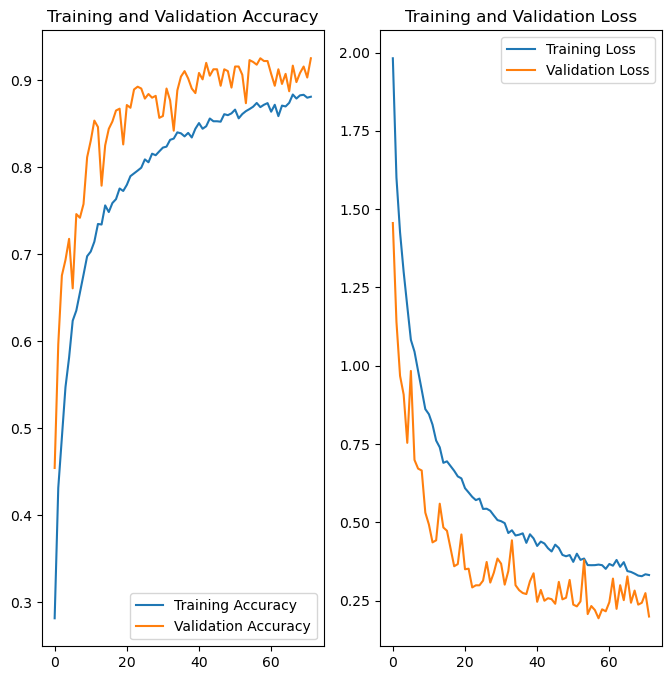

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
t = time.time()

export_path_keras = "./M3/{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./M3/1672622683.h5


In [49]:
# reload
reloaded = tf.keras.models.load_model(
  './M3/1672622683.h5', 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

In [50]:
# predict the testdata
test_dir = '../plant-seedlings-classification/test'
testdata_dir = test_dir + '/testdata'
le = LabelEncoder()
le.fit(os.listdir(train_dir))
testdata = os.listdir(testdata_dir)
test_tal_num = 0
im = []
allimages= []
img_path = os.path.join(test_dir, 'testdata_b')
images = glob.glob(img_path + '/*.png')
allimages.extend(images)
#print("{}: {} Images".format(cl, len(images)))
test_tal_num += len(images)
#num_train = int(round(len(images)*0.8))
#train, val = images[:num_train], images[num_train:]
for i in range(len(images)):
    img = cv2.imread(allimages[i])
    img = tf.image.resize(img, [150,150])
    im.append(img)
im = np.array(im)/255.0
predictions = reloaded.predict(im)

25/25 [==============================] - 1s 33ms/step


In [51]:
results = []
for i in range(predictions.shape[0]):
    results.append(np.argmax(predictions[i]))
PredStr = list(le.inverse_transform(results))
result = {'file':testdata,'species':PredStr}
result = pd.DataFrame(result)
result.to_csv("Prediction_M3.csv",index=False)
#score : 0.84

30/30 [==============================] - 1s 29ms/step


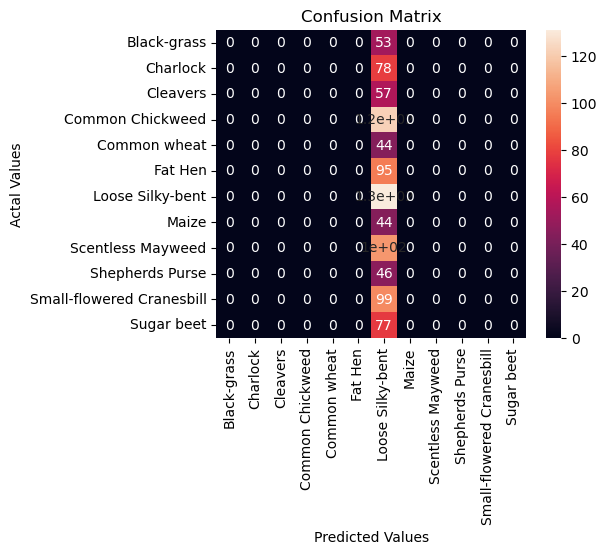

In [53]:
# confution matrix
X_val = X_val/255
prediction_val = reloaded.predict(X_val)
results_val = []
for i in range(prediction_val.shape[0]):
    results_val.append(np.argmax(prediction_val[i]))
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_val, results_val)
cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()